In [1]:
import pickle
import pandas as pd
import os
import setup

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import wandb
from torch.utils.data.sampler import SubsetRandomSampler
import pprint
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import MinMaxScaler
import math
from torch.profiler import profile, record_function, ProfilerActivity

from operator import itemgetter
import operator
from random import randint
# from rnn_classes import Dog, DogInput, Race, Races, GRUNet, smallGRUNet, smalll_lin_GRUNet, smalll_prelin_GRUNet
import rnn_tools.rnn_classes as rnn_classes
import json
import plotly.graph_objs as go

In [27]:
# model_all_price/RL40rich-brook-43 - val_all_price_df.fth model_all_price/RL40rich-brook-43 - all_price_df.fth

In [2]:
model_name  = 'wandering-snowball-228'
epoch = 850
all_price_df = pd.read_feather(f'model_all_price/{epoch}{model_name} - all_price_df.fth')
all_price_df
all_price_df2 = pd.read_feather(f'model_all_price/{epoch}{model_name} - val_all_price_df.fth')
all_price_df = pd.concat([all_price_df, all_price_df2])

In [3]:
all_price_df.date.min()


datetime.date(2023, 1, 1)

In [4]:
all_price_df.columns

Index(['index', 'raw_margins', 'correct', 'simple', 'win_price', 'relu',
       'output', 'output_p', 'p', 'bet_amount_model', 'output_price',
       'pred_logit', 'pred_prob', 'pred_prob2', 'prices', 'imp_prob',
       'pred_price', 'pred_price1', 'pred_price2', 'classes', 'track',
       'onehot_win', 'dogID', 'dog_name', 'dog_box', 'raceID', 'date',
       'entropy', 'mutual_info', 'race_num', 'loss', 'loss_bfsp',
       'favorite_correct', 'one_hot_win', 'bet_amount', 'profit',
       'seq_kelly_ratio', 'bet_kelly_seq', 'profit_kelly_sq', 'colour',
       'profit < 30', 'outlay < 30', 'bet_amount2', 'profit2',
       'bet_amount_kelly', 'profit_kelly', 'profit < 30 2', 'outlay < 30 2',
       'bet_relu', 'profit_relu', 'bet_relu<30', 'profit_relu<30', 'kl_div',
       'kl_div_bfsp', 'win < 30', 'win', 'bet_count', 'bet_count < 30',
       'profit_model', 'profit_model < 30', 'round_price'],
      dtype='object')

In [5]:
all_price_df.race_num.astype(int).value_counts(sort=False)

race_num
10     8209
9      8780
11     6208
1     10305
7      9500
8      9127
6     10345
4     10307
12     4272
3     10240
5     10457
2     10290
Name: count, dtype: int64

In [6]:
all_price_df.to_parquet(f'model_all_price/{model_name} - all_price_df.pqt')

In [141]:
all_price_df.to_excel(f'model_all_price/{model_name} - all_price_df.xlsx')

In [6]:
# model_name = 'rich-brook-43'
# all_price_df = pd.read_excel(f'model_all_price/{model_name} - all_price_df.xlsx')

In [152]:
all_price_df = pd.read_excel(f'model_all_price/{model_name} - all_price_df.xlsx')

In [4]:
price_df  = all_price_df.groupby('round_price')[['bet_amount_model', 'profit_model']].sum().cumsum().reset_index()


In [5]:
import plotly.graph_objects as go
price_df['roi'] = price_df['profit_model'] / price_df['bet_amount_model']
price_df = price_df.query('round_price < 100.0')
# Create a trace for ROI
trace_roi = go.Scatter(
    x = price_df['round_price'],
    y = price_df['roi'],
    mode = 'lines',
    name = 'Profit Model'
)

data = [trace_roi]

# Define layout
layout = go.Layout(
    title = 'Interactive Plot',
    xaxis = dict(title = 'Round Price'),
    yaxis = dict(title = 'Amount'),
)

# Define the figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


In [6]:
all_price_df['dt'] = pd.to_datetime(all_price_df['date']).dt.date

In [7]:
all_price_df = all_price_df.sort_values('dt',ascending=True)

In [13]:
model_name  = 'fiery-haze-173'
all_price_df2 = pd.read_feather(f'model_all_price/{epoch}{model_name} - val_all_price_df.fth')

FileNotFoundError: [Errno 2] No such file or directory: 'model_all_price/1100fiery-haze-173 - val_all_price_df.fth'

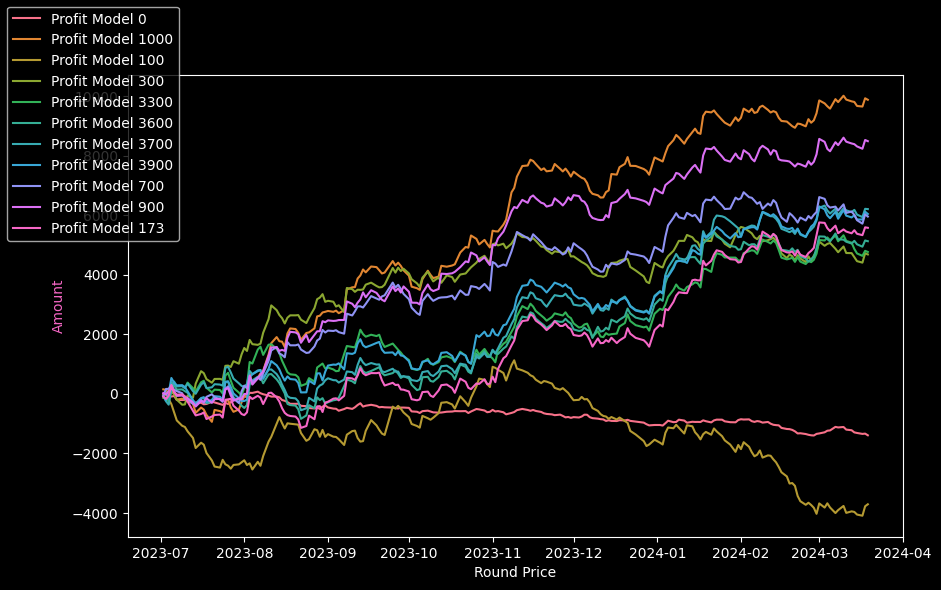

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import re
model_name  = 'fiery-haze-173'
files = glob.glob(f'model_all_price/*{model_name}* - val_all_price_df.fth')

# Create a figure and a single axis
fig, ax1 = plt.subplots(figsize=(10, 6))

colors = sns.color_palette('husl', len(files))
for i,file in enumerate(files):
    all_price_df = pd.read_feather(file)
    all_price_df['dt'] = pd.to_datetime(all_price_df['date']).dt.date

    date = all_price_df.query('round_price <= 24.0').copy()

    date['bet_amount_model'] = np.where(date['bet_amount_model'] > 0.1, date['bet_amount_model'], 0)*10*2
    date['profit_model'] = np.where(date['bet_amount_model'] > 0.1, date['profit_model'], 0)*10*2

    date = date.groupby('dt',sort=False)[['bet_amount_model', 'profit_model','round_price']].sum().cumsum().reset_index()
    date['roi'] = date['profit_model'] / date['bet_amount_model']
    epoch_number = re.search(r'\d+', file).group()
    # Plot the 'Profit Model' on the first axis
    color = colors[i]
    ax1.plot(date['dt'], date['profit_model'], label=f'Profit Model {epoch_number}', color=color)
    ax1.set_xlabel('Round Price')
    ax1.set_ylabel('Amount', color=color)

    # Create a second axis that shares the same x-axis
    # ax2 = ax1.twinx()

    # Plot the 'roi' on the second axis
    color = sns.color_palette()[1]
    # ax2.plot(date['dt'], date['roi'], label=f'roi {file}', color=color)
    # ax2.set_ylabel('roi', color=color)

# Show the legend
fig.legend(loc="upper left")

# Show the plot
plt.show()

In [49]:
all_price_df.columns

Index(['index', 'raw_margins', 'correct', 'simple', 'win_price', 'relu',
       'bet_amount_model', 'output_price', 'pred_logit', 'pred_prob',
       'pred_prob2', 'prices', 'imp_prob', 'pred_price', 'pred_price1',
       'pred_price2', 'classes', 'track', 'onehot_win', 'dogID', 'dog_name',
       'dog_box', 'raceID', 'date', 'entropy', 'mutual_info', 'race_num',
       'loss', 'loss_bfsp', 'favorite_correct', 'one_hot_win', 'bet_amount',
       'profit', 'seq_kelly_ratio', 'bet_kelly_seq', 'profit_kelly_sq',
       'colour', 'profit < 30', 'outlay < 30', 'bet_amount2', 'profit2',
       'bet_amount_kelly', 'profit_kelly', 'profit < 30 2', 'outlay < 30 2',
       'bet_relu', 'profit_relu', 'bet_relu<30', 'profit_relu<30', 'kl_div',
       'kl_div_bfsp', 'win < 30', 'win', 'bet_count', 'bet_count < 30',
       'profit_model', 'round_price', 'dt', 'roi'],
      dtype='object')

In [52]:
price_df  = all_price_df.query('round_price < 30').groupby('raceID')[['bet_amount_model', 'profit_model']].sum()

In [53]:
price_df

,bet_amount_model,profit_model
raceID,,
1001127258,9.636954e-26,-9.393410e-26
1001127259,9.995718e-01,-9.856390e-01
1001127260,1.000000e+00,1.994846e+00
1001127261,1.000000e+00,-9.856547e-01
1001127262,1.000000e+00,5.003411e+00
...,...,...
998764233,1.000000e+00,-1.000000e+00
998764234,1.000000e+00,-1.000000e+00
998764235,1.000000e+00,-9.997356e-01


In [44]:
all_price_df.query('round_price < 30')['profit_model'].mean()

0.02242961779237248

In [125]:
all_price_df['roi'] = all_price_df['profit_model'] / all_price_df['bet_amount_model']

In [108]:
price_df  = all_price_df.query('round_price < 30').groupby('raceID')[['bet_amount_model', 'profit_model']].sum()

In [109]:
price_df

,bet_amount_model,profit_model
raceID,,
1001127258,9.636954e-26,-9.393410e-26
1001127259,9.995718e-01,-9.856390e-01
1001127260,1.000000e+00,1.994846e+00
1001127261,1.000000e+00,-9.856547e-01
1001127262,1.000000e+00,5.003411e+00
...,...,...
998764233,1.000000e+00,-1.000000e+00
998764234,1.000000e+00,-1.000000e+00
998764235,1.000000e+00,-9.997356e-01


In [110]:
price_df.mean()

bet_amount_model    0.768264
profit_model        0.131747
dtype: float64

In [130]:
import scipy.stats as stats
model_name  = 'fiery-haze-173'
# file
# Concatenate all profit_model data from all files
# all_profits =  pd.read_parquet('model_all_price/fiery-haze-173 - all_price_df.pqt')['profit_model']
# all_price_df = price_df
all_price_df['roi'] = all_price_df['profit_model'] / all_price_df['bet_amount_model']
all_price_df = all_price_df.query('bet_amount_model > 0.10 and prices < 30').copy()
all_profits = all_price_df['roi']
all_profits.dropna(inplace=True)
# Perform the t-test
t_stat, p_value = stats.ttest_1samp(all_profits, 0.15)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: -0.33311662403011916
P-value: 0.7390596064114099


In [131]:
all_price_df

,index,raw_margins,correct,simple,win_price,relu,bet_amount_model,output_price,pred_logit,pred_prob,...,kl_div,kl_div_bfsp,win < 30,win,bet_count,bet_count < 30,profit_model,round_price,dt,roi
55,90,10.3,0.0,0.000000,8.031140,0.007617,0.208047,6.433496,0.255942,0.155436,...,-0.107812,-0.114197,0,0,1,1,-0.208047,12.0,2023-01-03,-1.000000
44,78,0.0,0.0,0.000000,5.743736,0.050699,0.254287,8.267488,0.265746,0.120956,...,-0.107812,-0.114197,0,0,0,0,1.145955,6.0,2023-01-03,4.506549
42,76,7.0,0.0,0.000000,5.743736,0.050699,0.745713,5.939426,0.596464,0.168366,...,-0.107812,-0.114197,0,0,0,0,-0.745713,5.0,2023-01-03,-1.000000
58,93,1.7,0.0,-1.000000,8.031140,0.007617,0.477873,4.743822,0.560616,0.210800,...,-0.107812,-0.114197,0,0,0,0,-0.477873,3.0,2023-01-03,-1.000000
59,94,3.6,0.0,0.000000,8.031140,0.007617,0.127906,5.969974,0.330717,0.167505,...,-0.107812,-0.114197,0,0,1,1,-0.127906,7.0,2023-01-03,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22244,28133,0.8,0.0,0.000000,3.006183,-0.016598,0.296677,6.353036,0.317132,0.157405,...,-0.113784,-0.121464,0,0,1,1,-0.296677,18.0,2024-03-19,-1.000000
22243,28132,5.9,0.0,0.000000,3.006183,-0.016598,0.669810,10.232540,-0.159508,0.097727,...,-0.113784,-0.121464,0,0,1,1,-0.669810,25.0,2024-03-19,-1.000000
22234,28122,7.3,0.0,0.000000,1.882411,-0.011332,0.949032,4.753406,1.065857,0.210375,...,-0.113784,-0.121464,0,0,1,1,-0.949032,5.0,2024-03-19,-1.000000
22252,28149,5.8,0.0,0.000000,6.400000,0.070048,0.999059,14.504270,-0.498823,0.068945,...,-0.113784,-0.121464,0,0,1,1,-0.999059,22.0,2024-03-19,-1.000000


In [136]:
import numpy as np
all_profits 
std_dev = all_profits.std()
num = all_profits.count()
print(f'Standard deviation: {std_dev}')

Z = 1.96  # z-score for 95% confidence level
E = 0.1  # desired margin of error

# Calculate the sample size
n = (Z**2 * std_dev**2) / E**2
n = np.ceil(n)  # round up to the nearest whole number because you can't have a fraction of a sample

print(f'Sample size: {n}, num = {num}')

Standard deviation: 3.2228340631181407
Sample size: 3991.0, num = 5230


In [ ]:
(Z**2 * std_dev**2)

In [60]:
all_profits.shape

(4974,)

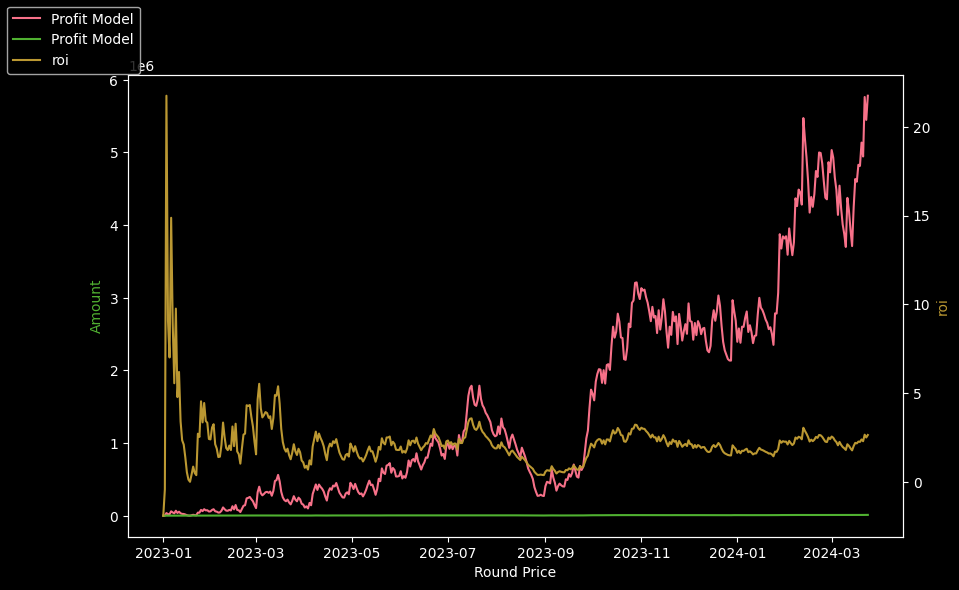

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn color palette as the default matplotlib color palette
sns.set_palette('husl')

# Your existing code
date = all_price_df.query('round_price < 30.0').copy()

date['bet_amount_model'] = np.where(date['bet_amount_model'] > 0.1, date['bet_amount_model'], 0)*10*2
date['profit_model'] = np.where(date['bet_amount_model'] > 0.1, date['profit_model'], 0)*10*2

date = date.groupby('dt',sort=False)[['bet_amount_model', 'profit_model','round_price']].sum().cumsum().reset_index()
date['balance'] = date['profit_model']
date['adj_bet'] = np.where(date['balance']*0.05>20, date['balance']*0.05,20)
date['adj_profit'] = date['adj_bet']*date['profit_model']
date['roi'] = date['profit_model'] / date['bet_amount_model']
date['adj_roi'] = date['adj_profit'] / (date['adj_bet'].cumsum()*20)
# Create a figure and a single axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the 'Profit Model' on the first axis
color = sns.color_palette()[0]
ax1.plot(date['dt'], date['adj_profit'], label='Profit Model', color=color)
ax1.set_xlabel('Round Price')
ax1.set_ylabel('Amount', color=color)

color = sns.color_palette()[2]
ax1.plot(date['dt'], date['profit_model'], label='Profit Model', color=color)
ax1.set_xlabel('Round Price')
ax1.set_ylabel('Amount', color=color)


# Create a second axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the 'roi' on the second axis
color = sns.color_palette()[1]
ax2.plot(date['dt'], date['adj_roi'], label='roi', color=color)
ax2.set_ylabel('roi', color=color)

# Show the legend
fig.legend(loc="upper left")

# Show the plot
plt.show()

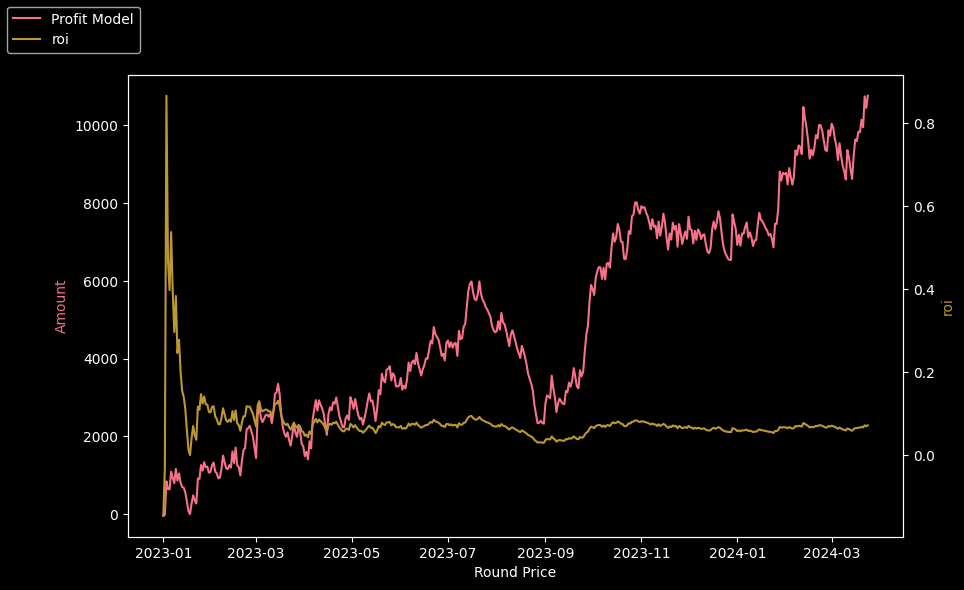

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn color palette as the default matplotlib color palette
sns.set_palette('husl')

# Your existing code
date = all_price_df.query('round_price < 30.0').copy()

date['bet_amount_model'] = np.where(date['bet_amount_model'] > 0.1, date['bet_amount_model'], 0)*10*2
date['profit_model'] = np.where(date['bet_amount_model'] > 0.1, date['profit_model'], 0)*10*2

date = date.groupby('dt',sort=False)[['bet_amount_model', 'profit_model','round_price']].sum().cumsum().reset_index()
date['roi'] = date['profit_model'] / date['bet_amount_model']

# Create a figure and a single axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the 'Profit Model' on the first axis
color = sns.color_palette()[0]
ax1.plot(date['dt'], date['profit_model'], label='Profit Model', color=color)
ax1.set_xlabel('Round Price')
ax1.set_ylabel('Amount', color=color)

# Create a second axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the 'roi' on the second axis
color = sns.color_palette()[1]
ax2.plot(date['dt'], date['roi'], label='roi', color=color)
ax2.set_ylabel('roi', color=color)

# Show the legend
fig.legend(loc="upper left")

# Show the plot
plt.show()

In [118]:
#Testing difference in data between server and local
local = pd.read_feather('./data/gru_inputs_kitchen_sink_updated_recent.fth')
server = pd.read_feather('./data/testing new outs simple 2024-03-24_NZ.fth')

In [119]:
local = local.rename({'stats':'stats_local','dog_id':'dogid'}, axis=1)
server = server.rename({'stats':'stats_server'}, axis=1)

In [127]:
local.query('raceid=="1009424823"')

,dogid,raceid,stats_local,prev_race_date
1572756,638803673,1009424823,"[1.0, 1.0, 0.0, 0.0, 25.8, 1.0, 375.0, 2.0, 17...",21 Mar 24
1572757,665430204,1009424823,"[7.0, 0.0, 0.0, 1.0, 25.8, 6.0, 318.0, 6.0, 16...",17 Mar 24
1572758,782101719,1009424823,"[2.0, 1.0, 0.0, 0.0, 31.4, 7.0, 457.0, 7.0, 17...",11 Mar 24
1572759,807472753,1009424823,"[6.0, 0.0, 1.0, 0.0, 25.7, 7.0, 318.0, 7.0, 16...",17 Mar 24
1572760,785257387,1009424823,"[4.0, 0.0, 1.0, 0.0, 35.1, 6.0, 375.0, 3.0, 17...",21 Mar 24
1572761,731358298,1009424823,"[8.0, 0.0, 0.0, 1.0, 28.5, 7.0, 318.0, 8.0, 16...",17 Mar 24
1572763,815513776,1009424823,"[5.0, 0.0, 1.0, 0.0, 27.8, 6.0, 375.0, 5.0, 17...",21 Mar 24


In [124]:
local = local[['dogid','raceid','stats_local','prev_race_date']]
merged = server.merge(local, on=['dogid','raceid'], how='left')

In [125]:
local.query('dogid == "760119322"')

,dogid,raceid,stats_local,prev_race_date
1569886,760119322,1007871256,"[7.0, 0.0, 0.0, 1.0, 27.3, 8.0, -1.0, -1.0, -1...",-1
1572742,760119322,1009424820,"[4.0, 0.0, 1.0, 0.0, 27.6, 8.0, 375.0, 7.0, 16...",21 Mar 24


In [126]:
merged['stats_diff'] = merged.apply(lambda x: (x['stats_local'] - x['stats_server']).sum(), axis=1)

In [128]:
dogid = "505983450"
stats_local = merged.query('dogid == @dogid')['stats_local'].to_list()[0]
stats_server = merged.query('dogid == @dogid')['stats_server'].to_list()[0]


In [129]:
stats_local.round(2).tolist()

[3.0,
 0.0,
 1.0,
 0.0,
 33.3,
 2.0,
 747.0,
 7.0,
 17.19,
 -1.0,
 -1.0,
 8.5,
 0.52,
 -1.0,
 -1.0,
 0.0,
 5.0,
 1.0,
 86.0,
 0.13,
 0.0,
 33.3,
 43.46,
 -1.0,
 11.1,
 0.09,
 654.0,
 3.5,
 17.13,
 16.92,
 0.2,
 2.26,
 0.15,
 34.12,
 17.18,
 0.0,
 5.4,
 2.0,
 16.0,
 0.25,
 3.0,
 32.5,
 37.58,
 4.3,
 0.0,
 0.04,
 625.6,
 3.0,
 16.91,
 16.82,
 0.37,
 8.51,
 0.58,
 26.86,
 17.06,
 0.0,
 6.0,
 -0.3,
 15.0,
 0.0,
 0.0,
 32.83,
 31.84,
 4.48,
 3.1,
 0.02,
 653.0,
 3.0,
 16.46,
 -1.0,
 -1.0,
 10.85,
 0.69,
 -1.0,
 -1.0,
 0.0,
 5.0,
 -1.5,
 2.0,
 0.0,
 0.0,
 32.9,
 31.84,
 -1.0,
 6.5,
 0.03,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0]

In [136]:
delta = pd.DataFrame([stats_server.round(2)[6:],stats_local.round(2)[6:]],columns=eval(merged['stats_cols'][0]))

In [66]:
local = local.query('state == "NZ"')

In [70]:
local

,index,dogid,dog_name,raceid,race_grade,date,race_time,race_num,trackOHE,track_name,...,runtime,prev_race,prev_race_date,prev_race_track,prev_race_state,place,margin,box,stats,stats_cols


In [110]:
server['stats_cols'][0]

"[['_dist_last__1', '_box_last__1', '_speed_avg_1', '_split_speed_avg_1', '_split_margin_avg_1', '_margin_avg_1', '_margin_time_avg_1', '_RunHomeTime_1', '_run_home_speed_1', '_first_out_avg_1', '_pos_out_avg_1', '_post_change_avg_1', '_races_1', '_wins_1', '_wins_last_1', '_weight_', '_min_time_', '_min_split_time_', '_last_start_price', '_last_start_prob', 'dist_dist_last__10', 'dist_box_last__10', 'dist_speed_avg_10', 'dist_split_speed_avg_10', 'dist_split_margin_avg_10', 'dist_margin_avg_10', 'dist_margin_time_avg_10', 'dist_RunHomeTime_10', 'dist_run_home_speed_10', 'dist_first_out_avg_10', 'dist_pos_out_avg_10', 'dist_post_change_avg_10', 'dist_races_10', 'dist_wins_10', 'dist_wins_last_10', 'dist_weight_', 'dist_min_time_', 'dist_min_split_time_', 'dist_last_start_price', 'dist_last_start_prob', 'box_dist_last__10', 'box_box_last__10', 'box_speed_avg_10', 'box_split_speed_avg_10', 'box_split_margin_avg_10', 'box_margin_avg_10', 'box_margin_time_avg_10', 'box_RunHomeTime_10', 'bo

In [37]:
df = df[[col for col in df.columns if '2' not in col and '<' not in col]]

In [38]:
df['bet_kelly_seq'] = np.where(
    df['prices']<30,
    df['seq_kelly_ratio']*100,
    0
)


df['profit_kelly_sq'] = np.where(
    df['onehot_win'],
    df['bet_kelly_seq']  * (df['prices'] - 1) * 0.95,
    -1 * df['bet_kelly_seq']
)

C:\Users\Nick\AppData\Local\Temp\ipykernel_22208\2227054136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bet_kelly_seq'] = np.where(
C:\Users\Nick\AppData\Local\Temp\ipykernel_22208\2227054136.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profit_kelly_sq'] = np.where(


In [41]:
df_30 = df[df['prices']<30]

In [42]:
df_30['profit_kelly_sq'].sum()/df_30['bet_kelly_seq'].sum()

-0.014917079482063344

In [43]:
df_30['profit_kelly'].sum()/df_30['bet_amount_kelly'].sum()

-0.05251907582272744

In [2]:
json_path = 'wandb_jsons/dancing-snake-80' 
files = os.listdir(json_path)
file_paths = [json_path + '/' + file for file in files]

for i,file in enumerate(file_paths):
    with open(file, 'r') as f:
        json_obj = json.load(f)

    # Create a DataFrame from the dictionary
    if i == 0:
        data = pd.DataFrame(data=json_obj["data"], columns=json_obj["columns"])
        data['step'] = i
    else:
        df = pd.DataFrame(data=json_obj["data"], columns=json_obj["columns"])
        df['step'] = i
        data = pd.concat([data, df])

In [3]:
data

,index,imp_prob,pred_prob,loss,onehot_win,mutual_info,step
0,0,0.284379,0.207907,0.314357,0.0,0.038062,0
1,1,0.339898,0.262791,0.059681,0.0,0.038062,0
2,2,0.060364,0.154242,0.001133,0.0,0.038062,0
3,3,0.037303,0.087363,0.024290,0.0,0.038062,0
4,4,0.069744,0.087032,0.022013,0.0,0.038062,0
...,...,...,...,...,...,...,...
9995,13010,0.050000,0.055298,0.000108,0.0,0.027519,98
9996,13011,0.052632,0.062132,0.278702,0.0,0.027519,98
9997,13012,0.041667,0.030744,0.316037,0.0,0.027519,98
9998,13013,0.128205,0.074162,0.005282,0.0,0.027519,98


In [4]:
df.filter

<bound method NDFrame.filter of       index  imp_prob  pred_prob      loss  onehot_win  mutual_info  step
0         0  0.284379   0.216534  0.306220         0.0     0.041786    98
1         1  0.339898   0.291799  0.055005         0.0     0.041786    98
2         2  0.060364   0.139676  0.001193         0.0     0.041786    98
3         3  0.037303   0.062424  0.027640         0.0     0.041786    98
4         4  0.069744   0.075048  0.023349         0.0     0.041786    98
...     ...       ...        ...       ...         ...          ...   ...
9995  13010  0.050000   0.055298  0.000108         0.0     0.027519    98
9996  13011  0.052632   0.062132  0.278702         0.0     0.027519    98
9997  13012  0.041667   0.030744  0.316037         0.0     0.027519    98
9998  13013  0.128205   0.074162  0.005282         0.0     0.027519    98
9999  13014  0.076923   0.084374  0.136110         0.0     0.027519    98

[10000 rows x 7 columns]>

In [8]:
df = data
df = data.query('onehot_win ==1')
# df = df.head(1000)

# Create a scatter plot for each step
# Create a scatter plot for each step
# Create a scatter plot for each step using Scattergl for WebGL
traces = [go.Scattergl(
    x=df['loss'][df['step'] == step].head(100),
    y=df['mutual_info'][df['step'] == step].head(100),
    mode='markers',
    visible=False,
    name=f'Step {step}'
) for step in df['step'].unique()]

# Make the first trace visible
traces[0]['visible'] = True

x_range = [df['loss'].min(), df['loss'].max()]
y_range = [df['mutual_info'].min(), df['mutual_info'].max()]

# Create a layout with a slider
layout = go.Layout(
    title='Loss vs Mutual Info',
    xaxis=dict(title='Loss'),
    yaxis=dict(title='Mutual Info'),
    sliders=[dict(
        active=0,
        currentvalue={"prefix": "Step: "},
        pad={"t": 50},
        steps=[dict(method='update',
                    args=[{'visible': [s == step for s in df['step'].unique()]}],
                    label=str(step)) for step in df['step'].unique()]
    )]
)

# Create a Figure
fig = go.Figure(data=traces, layout=layout)

# Display the figure
fig.show()